In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Loading

In [17]:

DATA_FILE="newspapers_filtered_2024-04-30_18-17-52_no_common_prefixes.jsonl"

from json import loads

data = [
    loads(line)
    for line in open(DATA_FILE, "r", encoding="utf-8").readlines()
]

print(f"Loaded {len(data)} records")

df = pd.DataFrame(data)

df["date"] = pd.to_datetime(df["date"])


Loaded 70805 records


In [18]:
EMBEDDINGS_FILE = f"{DATA_FILE.removesuffix('.jsonl')}_embeddings.npy"

embeddings = np.load(EMBEDDINGS_FILE)

df["embedding"] = [e for e in embeddings]

print(f"Loaded {len(embeddings)} embeddings")

assert len(df) == len(embeddings)

Loaded 70805 embeddings


In [19]:
df.iloc[0]

title             International de Sète : la pétanque, une affai...
text              L'international de pétanque de Sète, avait lie...
date                                            2022-03-07 00:00:00
article_id                                                  2047761
article_url       https://france3-regions.francetvinfo.fr/occitanie
article_domain                      france3-regions.francetvinfo.fr
embedding         [-0.02630615234375, 0.0106658935546875, 0.0487...
Name: 0, dtype: object

# HDBSCAN

In [20]:
import hdbscan

MIN_CLUSTER_SIZE = 10

## Dimension reduction using UMAP

In [21]:
from umap import UMAP

# Specify the desired number of dimensions (K)
K = MIN_CLUSTER_SIZE

# Create a UMAP object with the specified number of dimensions
umap_reducer = UMAP(n_components=K, random_state=42)

# Fit and transform the embeddings to reduce dimensionality
umap_embeddings = umap_reducer.fit_transform(df['embedding'].tolist())

# Set the reduced embeddings as a list to each row in the DataFrame
df[f'umap_embedding{K}'] = umap_embeddings.tolist()

c:\Users\samue\phd-track-event-detection\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## Adding the date as a clustering feature

In [22]:
df.sort_values("date", inplace=True)

In [23]:
# Convert date to a numerical feature
df['date_feature'] = df['date'].astype('int64') / 10**16  # Adjust the scaling factor as needed

### Set features column

In [24]:
# Combine the UMAP embedding and date feature
df['combined_features'] = df.apply(lambda row: row[f'umap_embedding{K}'] + [row['date_feature']], axis=1)

### Perform HDBSCAN clustering

In [25]:
model = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, metric='euclidean', cluster_selection_method='eom')
labels = model.fit_predict(df['combined_features'].tolist())
df['cluster'] = labels

# Analyse clusters

In [26]:
# show titles from the biggest cluster (except noise cluster)


biggest_cluster = df[df['cluster']!=-1].value_counts('cluster').idxmax()

df[df['cluster']==biggest_cluster].sort_values('date')[['date', 'title']]

,date,title
20646,2022-02-11,Jean Alesi en garde à vue à Avignon : ce que l...
21124,2022-02-11,Les archives du crime en Lot-et-Garonne : la b...
10295,2022-02-11,Pyrénées-Orientales : le maire du Barcarès Ala...
1505,2022-02-14,Vaucluse : opération anti-drogue des gendarmes...
70771,2022-02-17,Bellevigne: une résidence secondaire cambriolée
...,...,...
58956,2023-12-27,Il débarque à l'hôtel de police avec un coutea...
10187,2023-12-27,"Surpris en flagrant délit, le voleur de trotti..."
7506,2023-12-28,Un jeune homme de 17 ans retrouvé blessé par b...
35692,2023-12-29,Meurtre d’un adolescent de 16 ans à Noël : tro...


In [61]:
for cluster in df['cluster'].unique()[:100]:
    min_date = df[df['cluster'] == cluster]['date'].min()
    max_date = df[df['cluster'] == cluster]['date'].max()
    duration = max_date - min_date

    print(f"Cluster {cluster} ({len(df[df['cluster'] == cluster])} articles, from {min_date} to {max_date}, duration: {duration})")
    for title in df[df['cluster'] == cluster].sort_values("date")["title"].head():
        print(f"  {title}")
    print()

Cluster -1 (45358 articles, from 2022-02-11 00:00:00 to 2024-02-13 00:00:00, duration: 732 days 00:00:00)
  Motos : le Villefranchois accueillera un enduro en octobre
  Toul : mobilisation pour l’offre de soins, "nous sommes inquiets, il faut défendre notre hôpital public"
  Fêtes de Bayonne : faites votre choix parmi les six affiches en compétition
  Bellevigne : un emploi administratif créé pour anticiper un départ à la retraite
  USP XV : les seniors, U19, U16 et U14 de Port-La Nouvelle sur le pont

Cluster 407 (2009 articles, from 2022-02-11 00:00:00 to 2023-12-29 00:00:00, duration: 686 days 00:00:00)
  Jean Alesi en garde à vue à Avignon : ce que l'on sait sur l'affaire impliquant l'ex pilote de F1
  Les archives du crime en Lot-et-Garonne : la belle et le notaire
  Pyrénées-Orientales : le maire du Barcarès Alain Ferrand libéré de prison
  Vaucluse : opération anti-drogue des gendarmes avec deux interpellations et des saisies d'argent, de cannabis, de cocaïne et d' héroïne
  Bel

### Number of clusters

Total number of clusters: 454


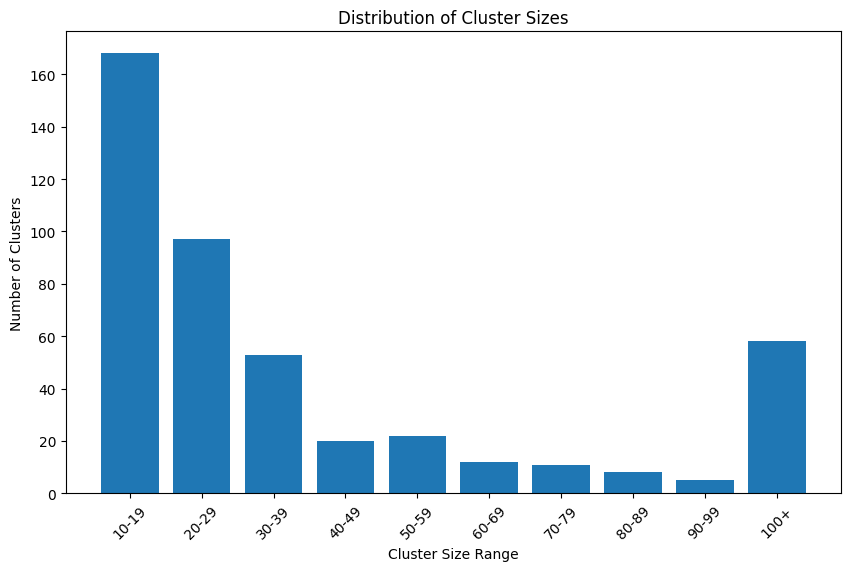

In [28]:

print(f"Total number of clusters: {df['cluster'].nunique()}")

# Get the cluster sizes
cluster_sizes = df['cluster'].value_counts()

# Define the bin edges
bin_edges = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]

# Create labels for the bins
bin_labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']

# Cut the cluster sizes into bins
binned_sizes = pd.cut(cluster_sizes, bins=bin_edges, labels=bin_labels, right=False)

# Count the number of clusters in each bin
bin_counts = binned_sizes.value_counts()

# Sort the bin counts in the desired order
bin_counts = bin_counts.reindex(bin_labels)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_counts.index, bin_counts.values)
plt.xlabel('Cluster Size Range')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Cluster Sizes')
plt.xticks(rotation=45)
plt.show()


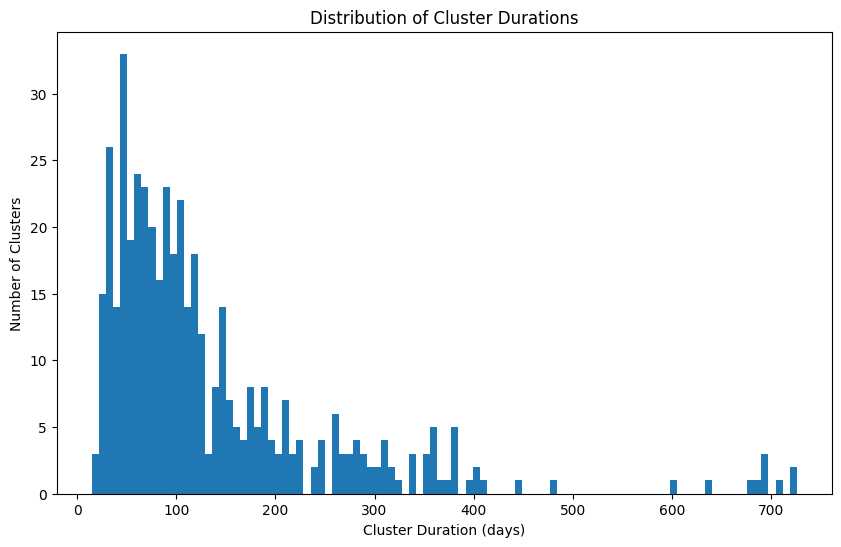

In [46]:
cluster_time_spans = []
for cluster in df['cluster'].unique():
    if cluster == -1:
        continue
    min_date = df[df['cluster'] == cluster]['date'].min()
    max_date = df[df['cluster'] == cluster]['date'].max()
    duration = max_date - min_date
    cluster_time_spans.append(duration)

# Convert the time spans to days
cluster_time_spans_days = [duration.days for duration in cluster_time_spans]

# Create a histogram of the cluster time spans

plt.figure(figsize=(10, 6))
plt.hist(cluster_time_spans_days, bins=100)
plt.xlabel('Cluster Duration (days)')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Cluster Durations')
plt.show()

# Generate a unified title for each cluster

In [29]:
from typing import List

def get_user_message(titles:List[str])->str:
    assert len(titles) > 0, "Please provide at least one title"
    titles_str = '\n'.join(titles)
    return f"""Here is a list of titles from a cluster of related French newspaper articles:

<article_titles>
{titles_str}
</article_titles>

Please read through these titles carefully and identify the common event that connects them. Write down your analysis of what these articles are discussing inside <thinking> tags.

Based on the common event you identified, generate a short title in French that unifies and summarizes the main subject of these articles. Aim for the title to be 2-5 words long. Output your generated title inside <title> tags. Keep your title concise. instead of "La Guerre en Ukraine", write "Guerre en Ukraine". Your task is not to find a common theme, but to find an event."""



In [30]:
# load anthropic client

from dotenv import load_dotenv
import os
import anthropic

load_dotenv()
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")


client = anthropic.Anthropic(
    api_key=ANTHROPIC_API_KEY,
)

In [31]:
titles = [
"Les débats de la présidentielle : faut-il légaliser le cannabis ?",
"Belfort. Un restaurant intègre du cannabis légal dans ses plats cette semaine",
"Société. Jérôme Durain : « Il faut légaliser l'usage du cannabis »"
]

import re

def generate_unified_title(titles:List[str]):
    user_message = get_user_message(titles)
    message = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=528,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": user_message
                    }
                ]
            }
        ]
    )

    answer = message.content[0].text
    # todo check token usage


    thinking = re.search(r'<thinking>(.*?)</thinking>', answer, re.DOTALL).group(1).strip()
    title = re.search(r'<title>(.*?)</title>', answer, re.DOTALL).group(1).strip()

    return thinking, title

In [41]:
# generate titles for a few clusters

NB_TITLES = 5 # Number of titles per cluster used to generate the unified title

cluster_to_title = {}

for cluster in df['cluster'].unique()[1:100]:
    print(f"Cluster {cluster}")

    # Get the list of embeddings
    embeddings = df[df['cluster'] == cluster][f'umap_embedding{K}'].tolist()

    # Convert to a 2D numpy array
    embeddings_array = np.array(embeddings)

    # Calculate the mean along the first axis
    centroid = embeddings_array.mean(axis=0)
    
    df['distance'] = df.apply(lambda row: np.linalg.norm(np.array(row[f'umap_embedding{K}']) - np.array(centroid)), axis=1)
    titles = df[df['cluster'] == cluster].sort_values("distance")['title'].head(NB_TITLES)

    print(f"Titles : {titles}")

    # Generate the unified title
    thinking, unified_title = generate_unified_title(titles)

    print(f"Unified title : {unified_title}")
    cluster_to_title[cluster] = unified_title
    print()
    

Cluster 407
Titles : 68089    Aunac : il s’énerve et s’en prend aux gendarme...
12806    Tirs d’airsoft entre Plérin et Saint-Quay : 18...
27385    Charente-Maritime : condamné pour avoir menacé...
15897    Son voisin dans le train refuse de discuter, i...
67197    Le Creusot. Viol sur une octogénaire : un homm...
Name: title, dtype: object
Unified title : Crimes et Condamnations

Cluster 164
Titles : 56322    Pro D2 : Béziers reçoit Grenoble ce vendredi à...
27690    En direct. Pro D2 : revivez la défaite de l'US...
27133    Rugby. Pro D2: ces Violets n’arrivent pas à pr...
13544    Pro D2 : Béziers réduit à 14 doit faire face à...
64888    Pro D2 : Béziers se saborde par son indiscipli...
Name: title, dtype: object
Unified title : Matchs Pro D2

Cluster 97
Titles : 8511     Ski alpin. OPA Cup U16 : une belle victoire po...
8931     Ski alpin. Léo Ducros ambitieux pour les Mondi...
40752    Ski chronique. Hugo Lapalus : "J’ai vécu telle...
48793    Ski Chrono Débrief. [VIDÉO] "L’équip